In [1]:
import psycopg2 #pip install psycopg2
import pandas as pd
import string
import numpy as np
import datetime
import jellyfish #pip install jellyfish
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
import qgrid #conda install -c conda-forge ipywidgets and pip install qgrid

qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to your /nbextensions folder

#DataBase Credentials
try:
    conn = psycopg2.connect(dbname='ebdb', user='ecorithm',
    host='fta-research.cogppnxvnbyw.us-west-2.rds.amazonaws.com', 
    password='research')
except:
   print "I am unable to connect to the database"

building_id = '27'

In [2]:
#SQL Command
cur = conn.cursor()

cur.execute("""SELECT unit.building_id::integer, unit.identifier,
fault.code,fault.interval_start 
FROM unit, fault 
WHERE fault.unit_id = unit.id AND unit.building_id = (%s) 
ORDER BY fault.interval_start"""
            ,[building_id])
rows = cur.fetchall()

In [3]:
#Loading in Pandas DataFrame
DF = pd.DataFrame(rows,columns = ['Building_ID','Device','FaultCode','Date'])

#Unique Fault Codes
Fault_Codes = list(set(DF['FaultCode']))
Fault_Codes.append('No_Fault')
#Unique Devices
Devices = list(set(DF['Device']))
#Unique Dates sorted
Dates = sorted(list(set(DF['Date'])))

In [4]:
#Mapping Alphabet to Fault Codes
Alpha_key = list(string.ascii_uppercase)[:len(Fault_Codes)]

Fault_Key = dict(zip(Fault_Codes, Alpha_key))
Fault_Key

{'DQ_METER': 'M',
 'DQ_SPACETEMP': 'K',
 'ESSB_AHU_MIXED_AIR_TEMP_ERROR': 'I',
 'ESSB_AHU_SCHEDULE': 'E',
 'ESSB_AHU_UNRESPONSIVE_COOLING_VALVE': 'H',
 'ESSB_DEVICE_SCHEDULE': 'J',
 'ESSB_FCU_INSUFFCOOLING_LOOPOUT': 'B',
 'ESSB_HW_LoopBelowSetPoint': 'C',
 'ESSB_VAV_AIRFLOWBELOWSETPOINT': 'G',
 'ESSB_VAV_EXCESSHEAT': 'D',
 'ESSB_VAV_INSUFFHEATING': 'A',
 'ESSB_VAV_SAT_Above_SpaceTemp': 'O',
 'ESSB_VAV_UNDERHEATING_FLOWBELOWSP': 'L',
 'ESSB_VAV_UNRESPONSIVE_OVERCOOLING': 'N',
 'No_Fault': 'P',
 'VAV_HEATING_HDF': 'F'}

In [5]:
Date_Indexs =[]
run_status = False

#For each Date

for date in Dates:
    Date_Indexs = DF[DF['Date']==date].index.values
    Date_Device =  DF['Device'][Date_Indexs].values
    Fault_List = []
    
    #For each device in Each Date
    
    for Device in Devices:
        index_values = []
        Fault_Code_Name =[]
        Fault = []
        
        #Check if there is a fault
        
        if Device in Date_Device:
           index_values = np.where(Date_Device == Device)[0]
           Fault_Code_Name = DF['FaultCode'][Date_Indexs[index_values]].values
        
        #If no fault, set fault name to 'No_Fault'
        
        else:
           Fault_Code_Name = list(['No_Fault'])
        Fault = Fault_Key[Fault_Code_Name[0]]
        
        #More than one fault for device
        if len(Fault_Code_Name) > 1:
           Fault += Fault_Key[Fault_Code_Name[1]]
        else:
           Fault += Fault_Key['No_Fault']
        if len(Fault_Code_Name) > 2:
            Fault += Fault_Key[Fault_Code_Name[2]]
        else:
           Fault += Fault_Key['No_Fault']

        #Add faults for device for each day in Alpha format
        Fault_List.append(Fault)
    
    #Append date to 
    new_column = pd.DataFrame({'Device': Devices, date.strftime('%m/%d/%y'): Fault_List})
    
    #Just for first loop to initialize the data frame
    if not run_status:
        exisiting_DF = new_column
    else:
        exisiting_DF = pd.merge(exisiting_DF,new_column,on='Device')
    run_status = True
Fault_Code_DataFrame_Daily = exisiting_DF.set_index(['Device'])

In [19]:
qgrid.show_grid(Fault_Code_DataFrame_Daily)

In [7]:
Per_Day = Fault_Code_DataFrame_Daily.sum(axis=0)
String_Per_Day = pd.DataFrame(Per_Day)
String_Per_Day.columns = ['String Value For All Devices Per Day']
qgrid.show_grid(String_Per_Day)

In [8]:
#  Distance Metric Calculator 
def PairWise_Distance_Levenshtien(Vector):
    #print Vector
    Distance = np.empty([Vector.shape[0],Vector.shape[0]])
    i = 0
    j = 0
    for row in Vector:
        for i in range(0,Vector.shape[0]):
            #print i
            dist =  jellyfish.levenshtein_distance(unicode(row),unicode(Vector[i]))
            Distance[i,j] = dist
        j +=1
    return Distance 

In [9]:
d = PairWise_Distance_Levenshtien(String_Per_Day['String Value For All Devices Per Day'])
clust = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001,
       precompute_distances='auto', verbose=0, 
               random_state=None, copy_x=True, n_jobs=1).fit_predict(d)

In [10]:
Cluster_Per_Date = pd.DataFrame({'Date':String_Per_Day.index.values,'Cluster Number':clust})
Cluster_Per_Date = Cluster_Per_Date.set_index('Date')
qgrid.show_grid(Cluster_Per_Date)

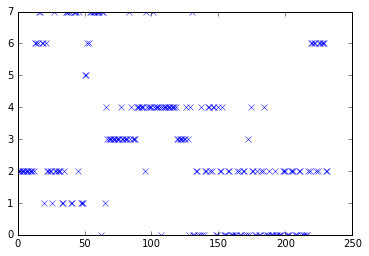

In [11]:
plt.plot(clust,'x')

In [12]:
Per_Device = Fault_Code_DataFrame_Daily.sum(axis=1)
String_Per_Device = pd.DataFrame(Per_Device)
String_Per_Device.columns = ['String Value Per Device For All Time']
String_Per_Device

String Value Per Device For All Time
Device                                                                
VAV_109              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_101              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_102              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_104              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
ElecMeter            MPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPM...
FCU_02               PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
FCU_01               PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
FCU_09               PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
FCU_08               PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_203              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_202              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_201              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_207              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_206              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...
VAV_205              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...
VAV_204              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_209              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_208              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...
VAV_423              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_420              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_210              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPA...
VAV_211              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_213              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...
VAV_214              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_215              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...
VAV_217              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...
VAV_218              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...
VAV_219              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...
RAD_222              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
RAD_305              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
...                                                                ...
HotWater             PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
AHU_L2_ReturnFanVFD  PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
WaterMeter           MPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPM...
Boiler02             PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
AHU_L2_SupplyFanVFD  PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
RAD_219              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
RAD_214              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_315              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_314              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_316              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_311              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_310              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_313              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
HWP03_VFD            PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
AHU_L1_ReturnFanVFD  PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_309              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_302              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_303              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_301              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_306              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_305              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_119              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPP...
VAV_113              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
VAV_112              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

In [13]:
d = PairWise_Distance_Levenshtien(String_Per_Device['String Value Per Device For All Time'])
clust = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001,
       precompute_distances='auto', verbose=0, 
               random_state=None, copy_x=True, n_jobs=1).fit_predict(d)

In [14]:
Per_Device_Total = pd.DataFrame({'Device':String_Per_Device.index.values,'Cluster Number':clust})
Per_Device_Total = Per_Device_Total.set_index('Device')
qgrid.show_grid(Per_Device_Total)

In [15]:
number_of_days = Fault_Code_DataFrame_Daily.shape[1]

header_names = Dates
start = 0
end = 28
step = 28
months = number_of_days/step + 1

for val in range(1,months):
    month_Name = header_names[end] 
    Fault_Selection = Fault_Code_DataFrame_Daily.iloc[:,start:end]
    New_Col=pd.DataFrame({'Device':Devices,month_Name.strftime('%b-%Y'): Fault_Selection.sum(1).values}) 
    if val==1:
       Fault_Code_Month = New_Col
    else:
       Fault_Code_Month = pd.merge(Fault_Code_Month,New_Col,on = 'Device')
    start += step
    end += step
Fault_Code_Month = Fault_Code_Month.set_index('Device')

In [16]:
Fault_Code_Month

Nov-2015  \
Device                                                                   
VAV_109              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_101              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_102              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_104              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
ElecMeter            MPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPM...   
FCU_02               PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
FCU_01               PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
FCU_09               PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
FCU_08               PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_203              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_202              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_201              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_207              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_206              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...   
VAV_205              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...   
VAV_204              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_209              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_208              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...   
VAV_423              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_420              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_210              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPA...   
VAV_211              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_213              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...   
VAV_214              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_215              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...   
VAV_217              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...   
VAV_218              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...   
VAV_219              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPPAPPA...   
RAD_222              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
RAD_305              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
...                                                                ...   
HotWater             PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
AHU_L2_ReturnFanVFD  PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
WaterMeter           MPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPMPPM...   
Boiler02             PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
AHU_L2_SupplyFanVFD  PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
RAD_219              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
RAD_214              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_315              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_314              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_316              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_311              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_310              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_313              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
HWP03_VFD            PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
AHU_L1_ReturnFanVFD  PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_309              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_302              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_303              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_301              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_306              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_305              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...   
VAV_119              PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPAPP

In [17]:
Headers = Fault_Code_Month.columns.values
count = 0
for month in Headers:
    d = PairWise_Distance_Levenshtien(Fault_Code_Month[month])
    clust = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001,
       precompute_distances='auto', verbose=0, 
               random_state=None, copy_x=True, n_jobs=1).fit_predict(d)
    New_Col=pd.DataFrame({'Device':Devices,month:clust}) 
    if count == 0:
       Per_Month_Cluster = New_Col
    else:
       Per_Month_Cluster = pd.merge(Per_Month_Cluster,New_Col,on = 'Device')
    count += 1

In [18]:
Per_Month_Cluster = Per_Month_Cluster.set_index('Device')
qgrid.show_grid(Per_Month_Cluster)